In [1]:
import os
import shutil
import pickle
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from datetime import date
from datetime import datetime
#from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf, month_plot # => noch pacf nutzen???
from statsmodels.tsa.seasonal import STL
from autots import AutoTS
from autots.evaluator.auto_model import remove_leading_zeros


# Data exploration

In [2]:
data = pd.read_csv("../data/traffic.csv", parse_dates=True, index_col="DateTime")
data.drop(["ID"], axis=1, inplace=True)
datetime_data = data.copy()
grouped_datetime_data = datetime_data.groupby(by="Junction")

In [3]:
junction_to_color_mapping = {
    1: "blue",
    2: "green",
    3: "red",
    4: "yellow",
}

In [4]:
def create_observation_count_per_junction_barplot(data_grouped_by_junction):
    fig, ax = plt.subplots(figsize=(8,5))
    
    x_values = []
    y_values = []
    color_list = []
    
    for key, group in data_grouped_by_junction:
        x_values.append(key)
        y_values.append(group.size)
        color_list.append(junction_to_color_mapping[key])
        
    ax.bar(x_values, y_values, color=color_list)
    ax.set_xticks(x_values)
    ax.set_xticklabels(
        map(lambda x: "junction_{0}".format(x), x_values)
    )
    ax.set_title("Number of datapoints available in the traffic dataset per junction", fontsize=15)
    ax.set_xlabel("Junctions present in the traffic dataset")
    ax.set_ylabel("Number of available datapoints")
    
    plt.savefig("./eda_plots/traffic_dataset_datapoint_per_junction_bar_plot.png")

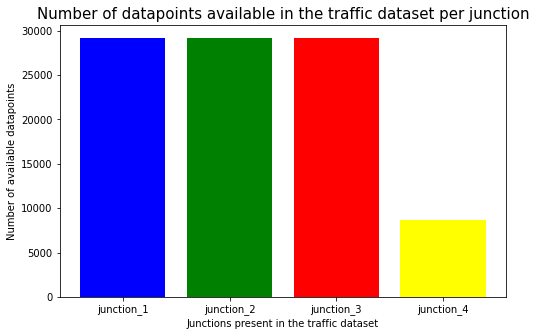

In [5]:
create_observation_count_per_junction_barplot(grouped_datetime_data)

In [6]:
def create_bar_plot_by_junction(data_grouped_by_junction):
    fig, axs = plt.subplots(4, 1, figsize=(20,25))
   
    
    for key, group in data_grouped_by_junction:
        vehicle_counts = group["Vehicles"].value_counts().sort_index()
        vehicle_counts.plot(
            kind="bar", 
            ax=axs[key - 1], 
            color=junction_to_color_mapping[key],
        )
        
        fig.suptitle(
            "Distinct vehicle count value occurences per junction of the traffic dataset",
            fontsize=20,
        )
        
        axs[key - 1].set_title(
            "Vehicle count value occurences at junction {0}".format(key), 
            fontsize=18,
        )
        axs[key - 1].set_xlabel(
            "Distinct vehicle count values", 
            fontsize=14,
        )
        axs[key - 1].set_ylabel(
            "Occurence of the distinct vehicle count values", 
            fontsize=14,
        )
        
    fig.tight_layout()
    fig.subplots_adjust(top=0.95)
        
    plt.savefig("./eda_plots/traffic_dataset_vehicle_count_per_junction_bar_plot.png")

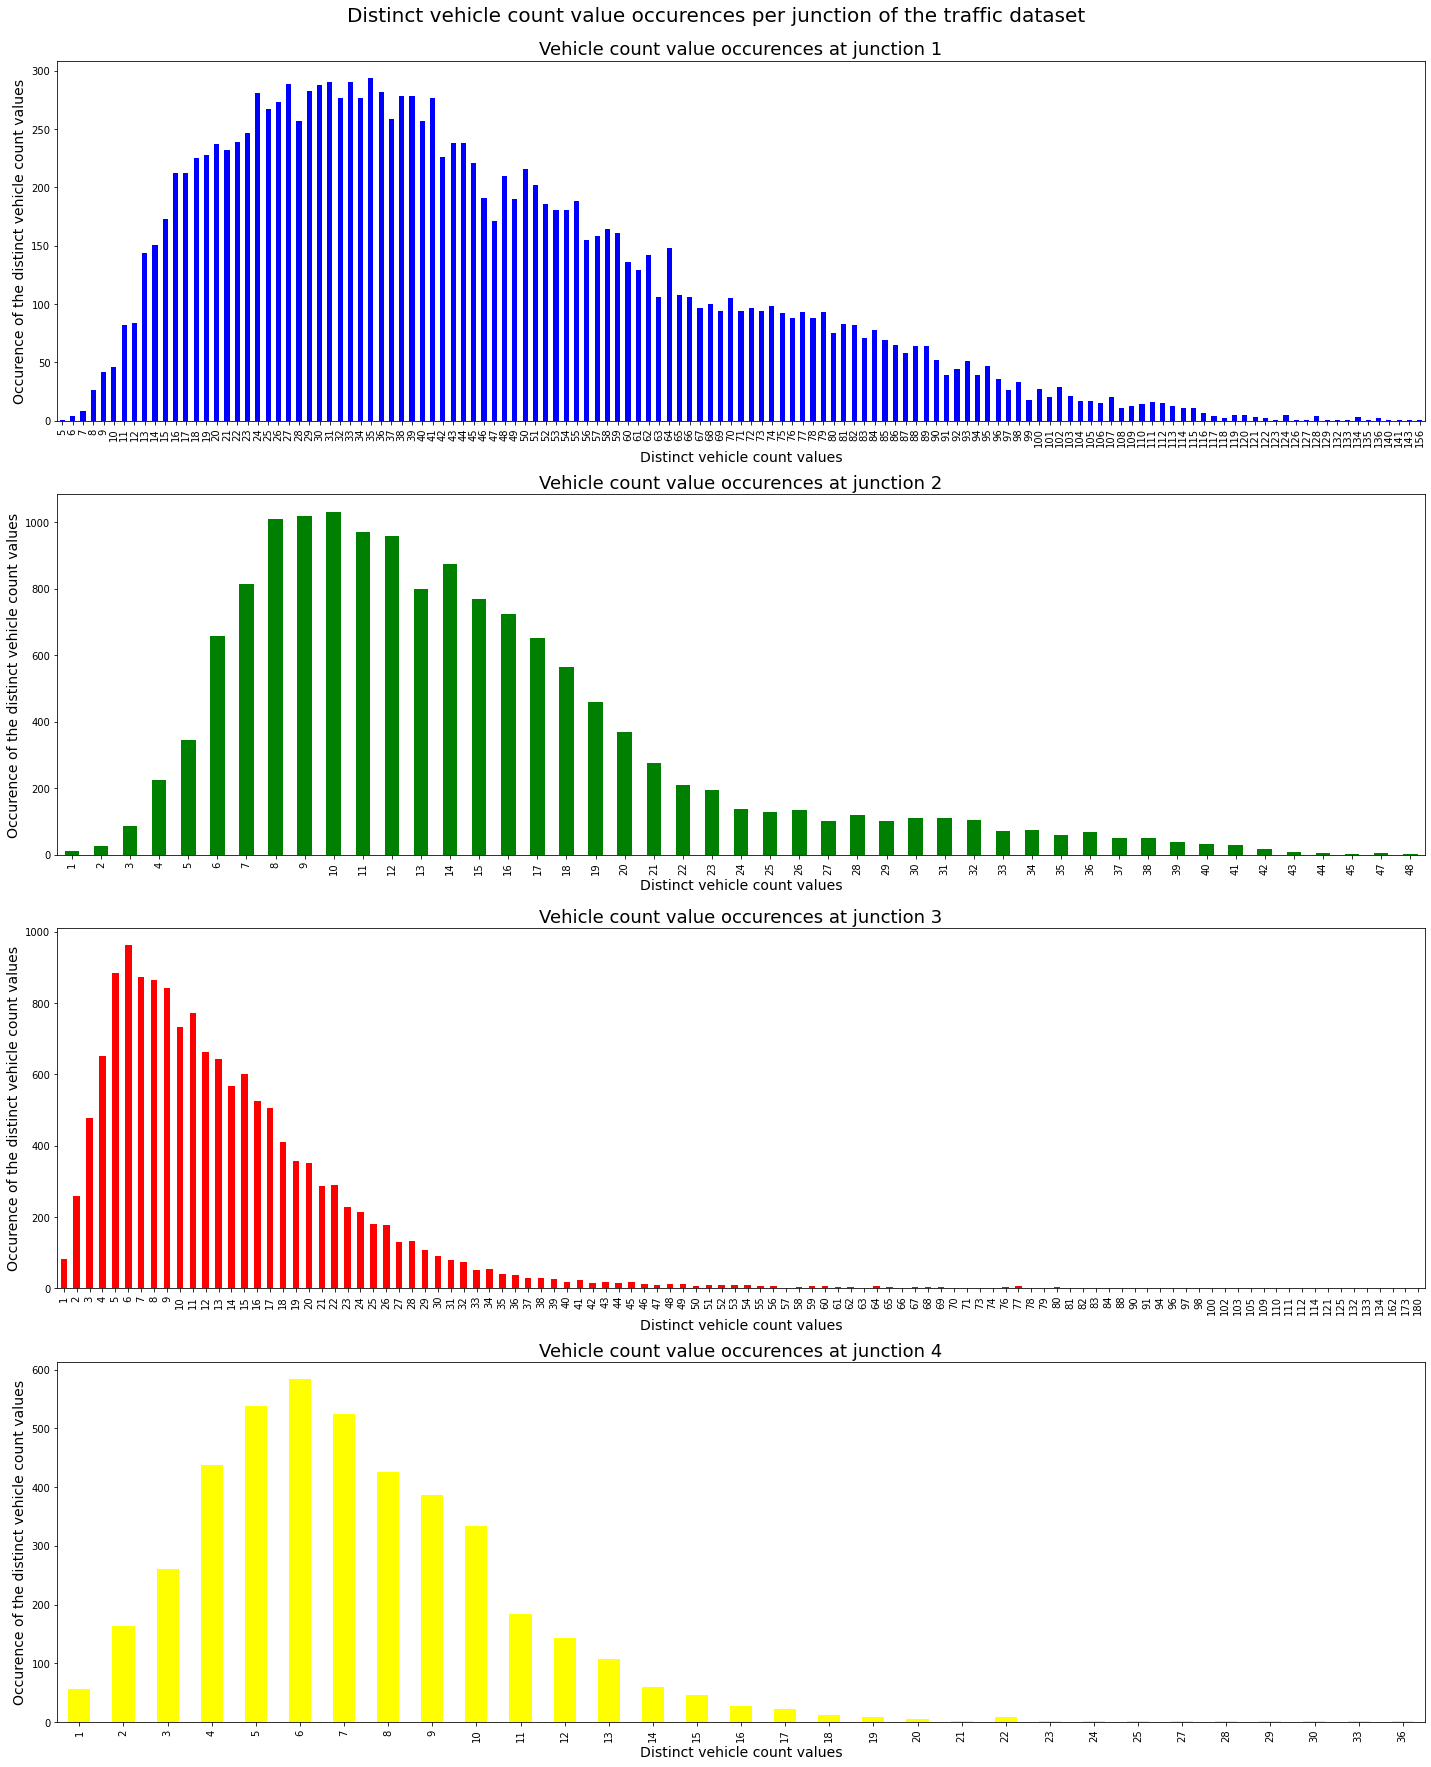

In [7]:
create_bar_plot_by_junction(grouped_datetime_data)

In [8]:
def create_hist_plot_by_junction(data_grouped_by_junction):
    fig, axs = plt.subplots(
        2, 
        2, 
        figsize=(25,20),
        sharex=True,
        sharey=True,
    )
    
    fig.suptitle(
            "Histograms of the vehicle counts of the traffic dataset"
            " per junction with identicall x and y axis scale",
            fontsize=30,
        )
    
    column = 0
    row = 0
    
    for key, group in data_grouped_by_junction:
        group.hist(
            ax=axs[column, row],
            column="Vehicles",
            bins=25,
            grid=False,
            color=junction_to_color_mapping[key],
        )
        
        axs[column, row].xaxis.set_tick_params(labelbottom=True)
        axs[column, row].yaxis.set_tick_params(labelbottom=True)
        axs[column, row].set_title(
            "Histogram for vehicle count data at junction {0}".format(key),
            fontsize=25,
        )
        axs[column, row].set_xlabel("Vehicle count values", fontsize=20,)
        axs[column, row].set_ylabel(
            "Occurence of values in specific vehicle count bin",
            fontsize=20,
        )
        
        axs[column, row].tick_params(labelsize=16)
    

        
        column = 0 if key % 2 == 0 else column + 1
        row = row + 1 if column % 2 == 0 else row
        
    fig.tight_layout()
    fig.subplots_adjust(top=0.92)

    plt.savefig("./eda_plots/traffic_dataset_vehicle_count_per_junction_hist.png")


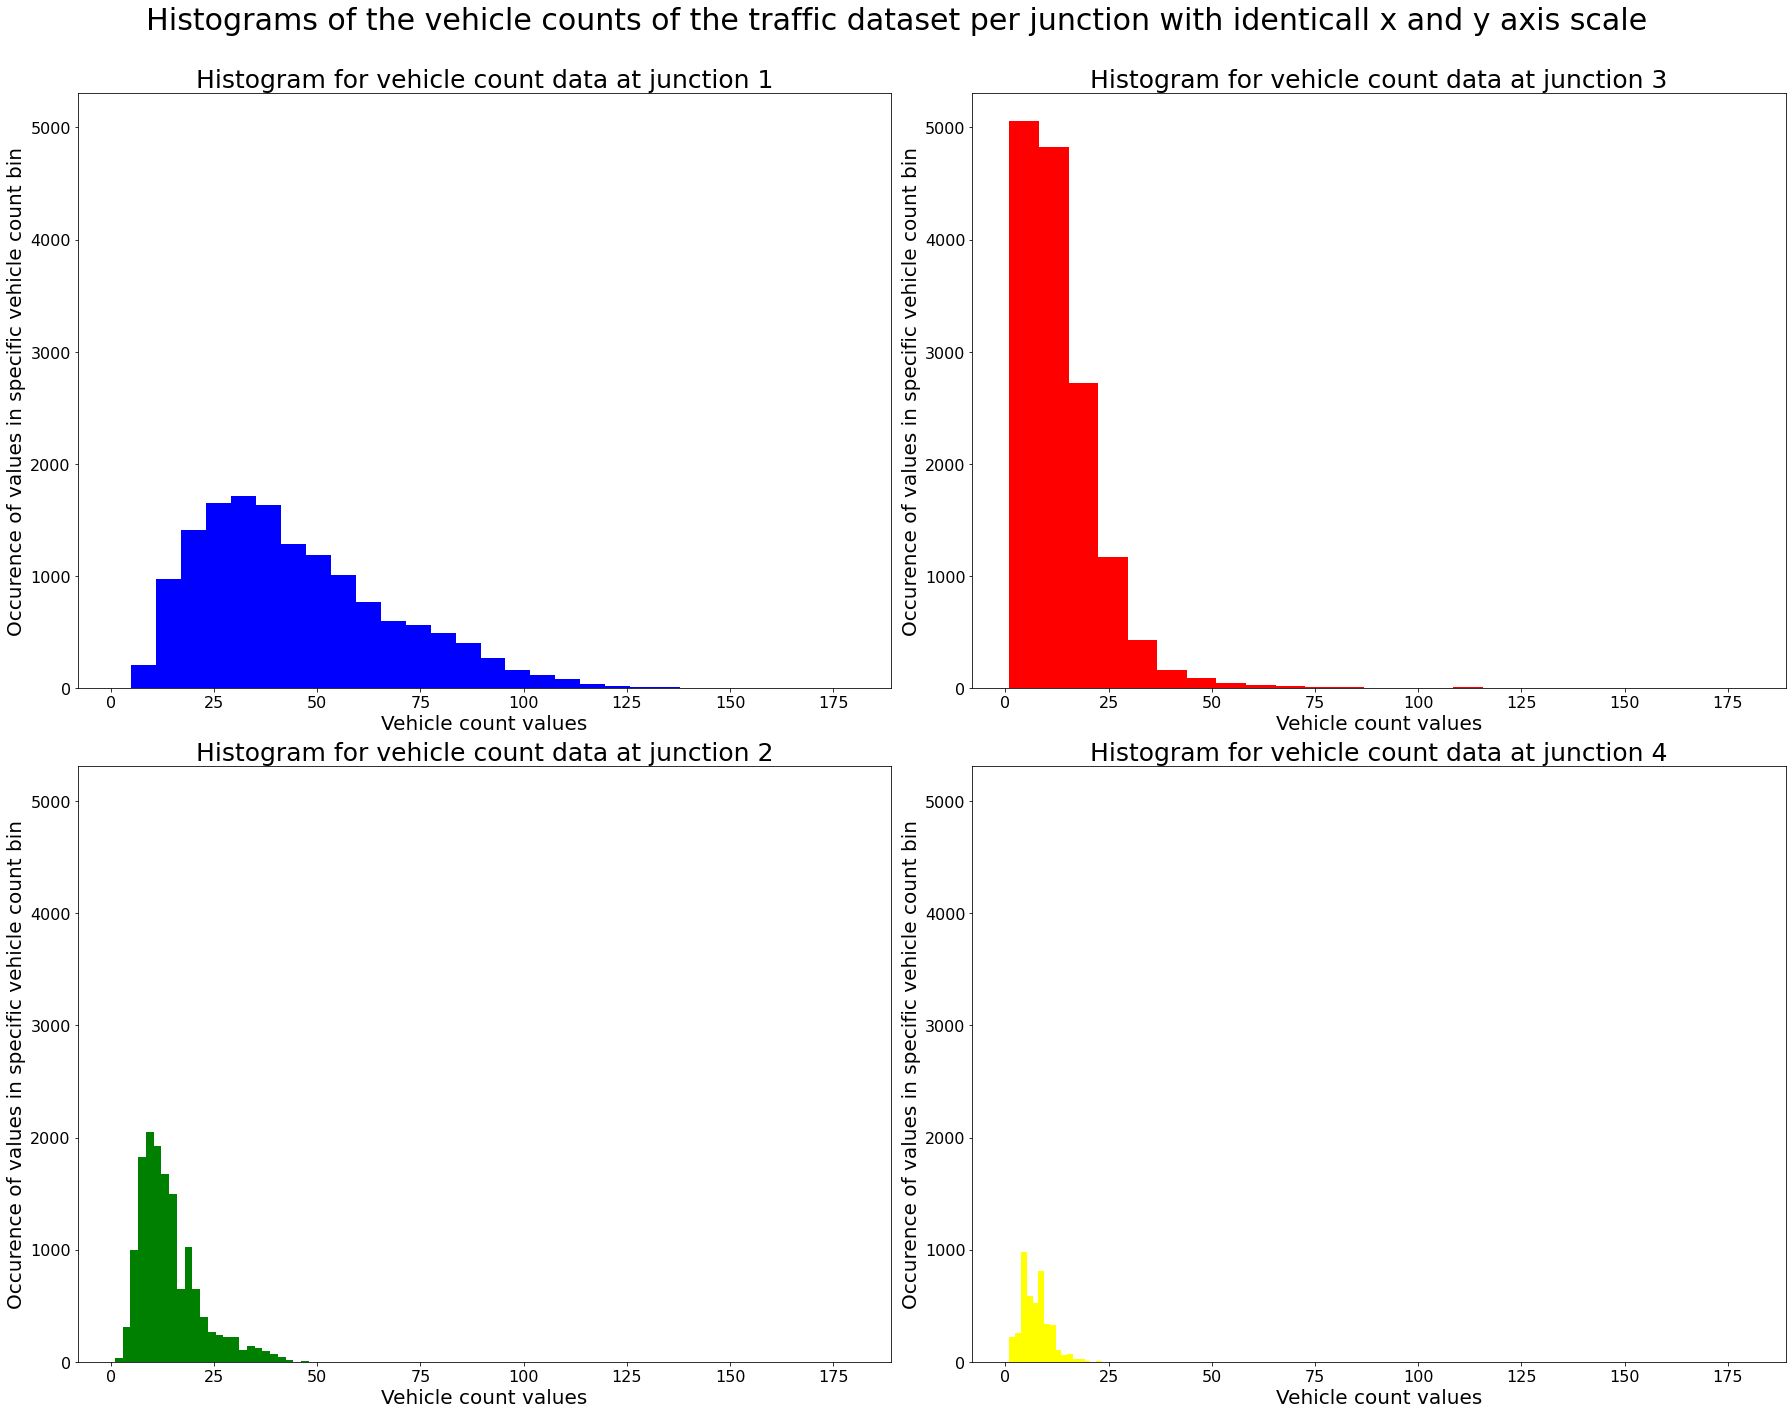

In [9]:
create_hist_plot_by_junction(grouped_datetime_data)

In [10]:
def plot_all_junction_timeseries_in_one_plot(data_grouped_by_junction, time_frequence_shown):
        fig, ax = plt.subplots(figsize=(25,12))
        
        frequency_mapping_dict = {
            "H": "Hour",
            "D": "Day",
            "W": "Week",
            "M": "Month",
            "Y": "Year",
        }
        
        for key, group in data_grouped_by_junction:
            group.drop(["Junction"], axis=1, inplace=True)
            resampled_data = group.resample(time_frequence_shown).mean()
            
            ax.plot(
                resampled_data, 
                color = junction_to_color_mapping[key],
                label = "junction_{0}".format(key)
            )
                    
        leg = ax.legend(fontsize="xx-large")

        for line in leg.get_lines():
            line.set_linewidth(6)
        
        if time_frequence_shown == "H":
            ax.set_title(
                ("{0}ly vehicle count per junction"        
                " in the traffic dataset").format(frequency_mapping_dict["H"]),
                fontsize = 25,
            )
        else:
            ax.set_title(
                ("{0}ly vehicle count per junction"        
                 " in the traffic dataset calculated as mean of the hourly dates").format(
                    frequency_mapping_dict[time_frequence_shown]
                ),
                fontsize = 25,
            )
        
        ax.set_xlabel("Timestamp t of data collection", fontsize=18)
        ax.set_ylabel("Vehicle count at time t", fontsize=18)
        
        plt.savefig(
            (
                "./eda_plots/traffic_dataset_combined"
                "_timeseries_plot_{0}_frequency.png"
            ).format(frequency_mapping_dict[time_frequence_shown])
        )

        
        # ggf abstand title plot vergrößern, ticks größerre font?

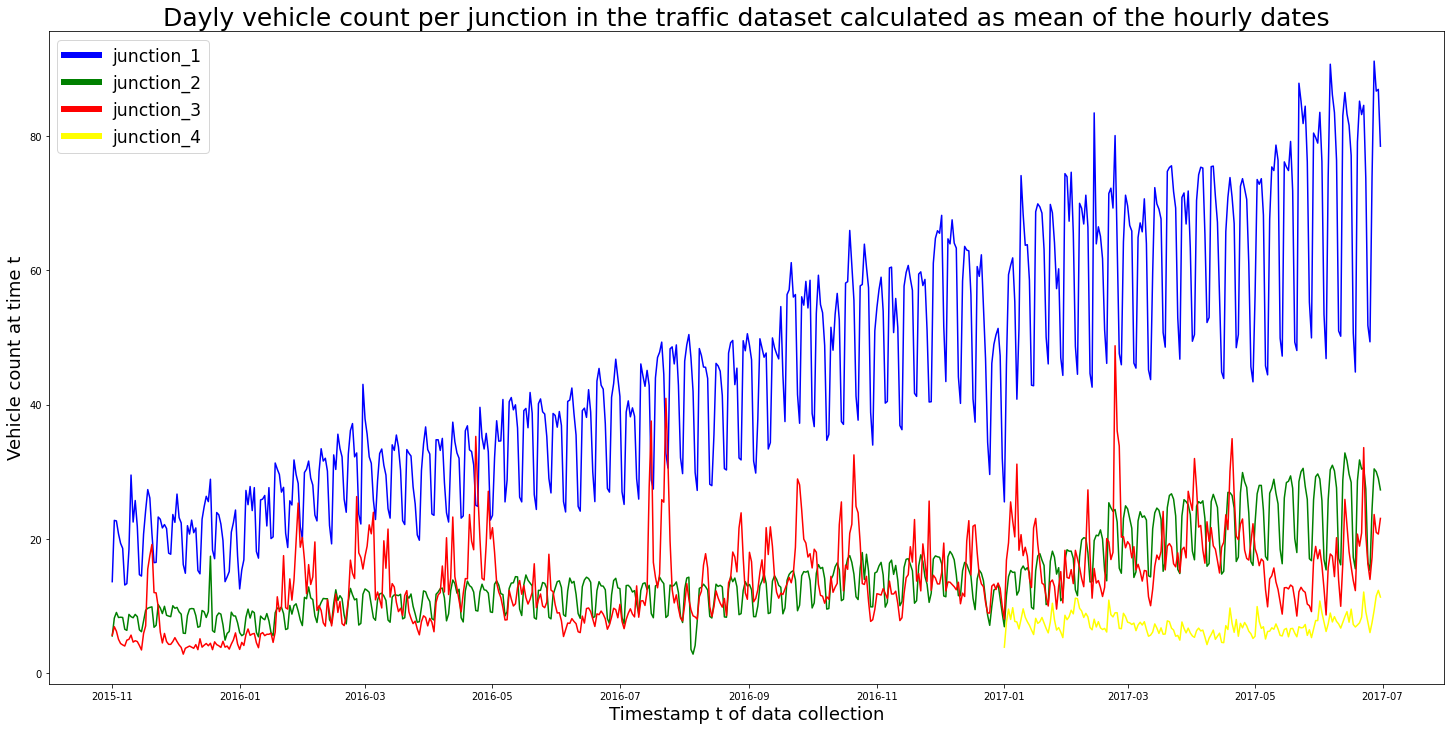

In [11]:
plot_all_junction_timeseries_in_one_plot(grouped_datetime_data, "D")

In [12]:
def plot_all_junction_timeseries_decomposition_in_one_plot(data_grouped_by_junction, time_frequence_shown):
    fig, axs = plt.subplots(
        nrows = 4, 
        ncols = 1, 
        figsize=(30,25),
    )
    
    frequency_mapping_dict = {
        "H": "Hour",
        "D": "Day",
        "W": "Week",
        "M": "Month",
        "Y": "Year",
    }
    
    for key, group in data_grouped_by_junction:
        group.drop(["Junction"], axis=1, inplace=True)
        resampled_data = group.resample(time_frequence_shown).mean()
        decomposed_ts = STL(resampled_data).fit()
        
        axs[0].plot(
            decomposed_ts.observed,
            color = junction_to_color_mapping[key],
            label = "junction_{0}".format(key),
        )
        axs[1].plot(
            decomposed_ts.trend,
            color = junction_to_color_mapping[key],
        )
        axs[2].plot(
            decomposed_ts.seasonal,
            color = junction_to_color_mapping[key],
        )
        axs[3].plot(
            decomposed_ts.resid,
            color = junction_to_color_mapping[key],
        )
        
        
    if time_frequence_shown == "H":
            fig.suptitle(
                ("Decomposition of the {0}ly vehicle count data per junction"        
                " in the traffic dataset").format(frequency_mapping_dict["H"]),
                fontsize = 30,
                y = 0.92,
            )
    else:
        fig.suptitle(
            ("Decomposition of the {0}ly vehicle count data per junction"        
             " in the traffic dataset calculated as mean of the hourly dates").format(
                frequency_mapping_dict[time_frequence_shown]
            ),
            fontsize = 30,
            y = 0.92,
        )
    
    axs[0].set_title("Observed time series data by junction", fontsize=24)
    axs[1].set_title("Trend component of time series data by junction", fontsize=24)
    axs[2].set_title("Seasonal component of time series data by junction", fontsize=24)
    axs[3].set_title("Residuals of time series data by junction", fontsize=24)
    
    #axs[0].set_xlabel("Timestamp t of data collection", fontsize=16)
    axs[0].set_ylabel("Vehicle count at time t", fontsize=20)
    #axs[1].set_xlabel("Timestamp t of data collection", fontsize=16)
    axs[1].set_ylabel("Vehicle count at time t", fontsize=20)
    #axs[2].set_xlabel("Timestamp t of data collection", fontsize=16)
    axs[2].set_ylabel("Vehicle count at time t", fontsize=20)
    axs[3].set_xlabel("Timestamp t of data collection", fontsize=20)
    axs[3].set_ylabel("Vehicle count at time t", fontsize=20)
    
    axs[0].tick_params(labelsize=16)
    axs[1].tick_params(labelsize=16)
    axs[2].tick_params(labelsize=16)
    axs[3].tick_params(labelsize=16)
        
    leg = fig.legend(
        fontsize="xx-large", 
        ncol = 2,
        bbox_to_anchor =(0.6, 0.095)
    )
    
    for line in leg.get_lines():
            line.set_linewidth(6)
            
    # y-achsen beschriftung anpassen!!!!!!!!!!!!!!!!!!!!!!!!!!!
    
    plt.savefig(
        "./eda_plots/timeseries_decomposition_per_junction.png",
        facecolor = "w",
    )

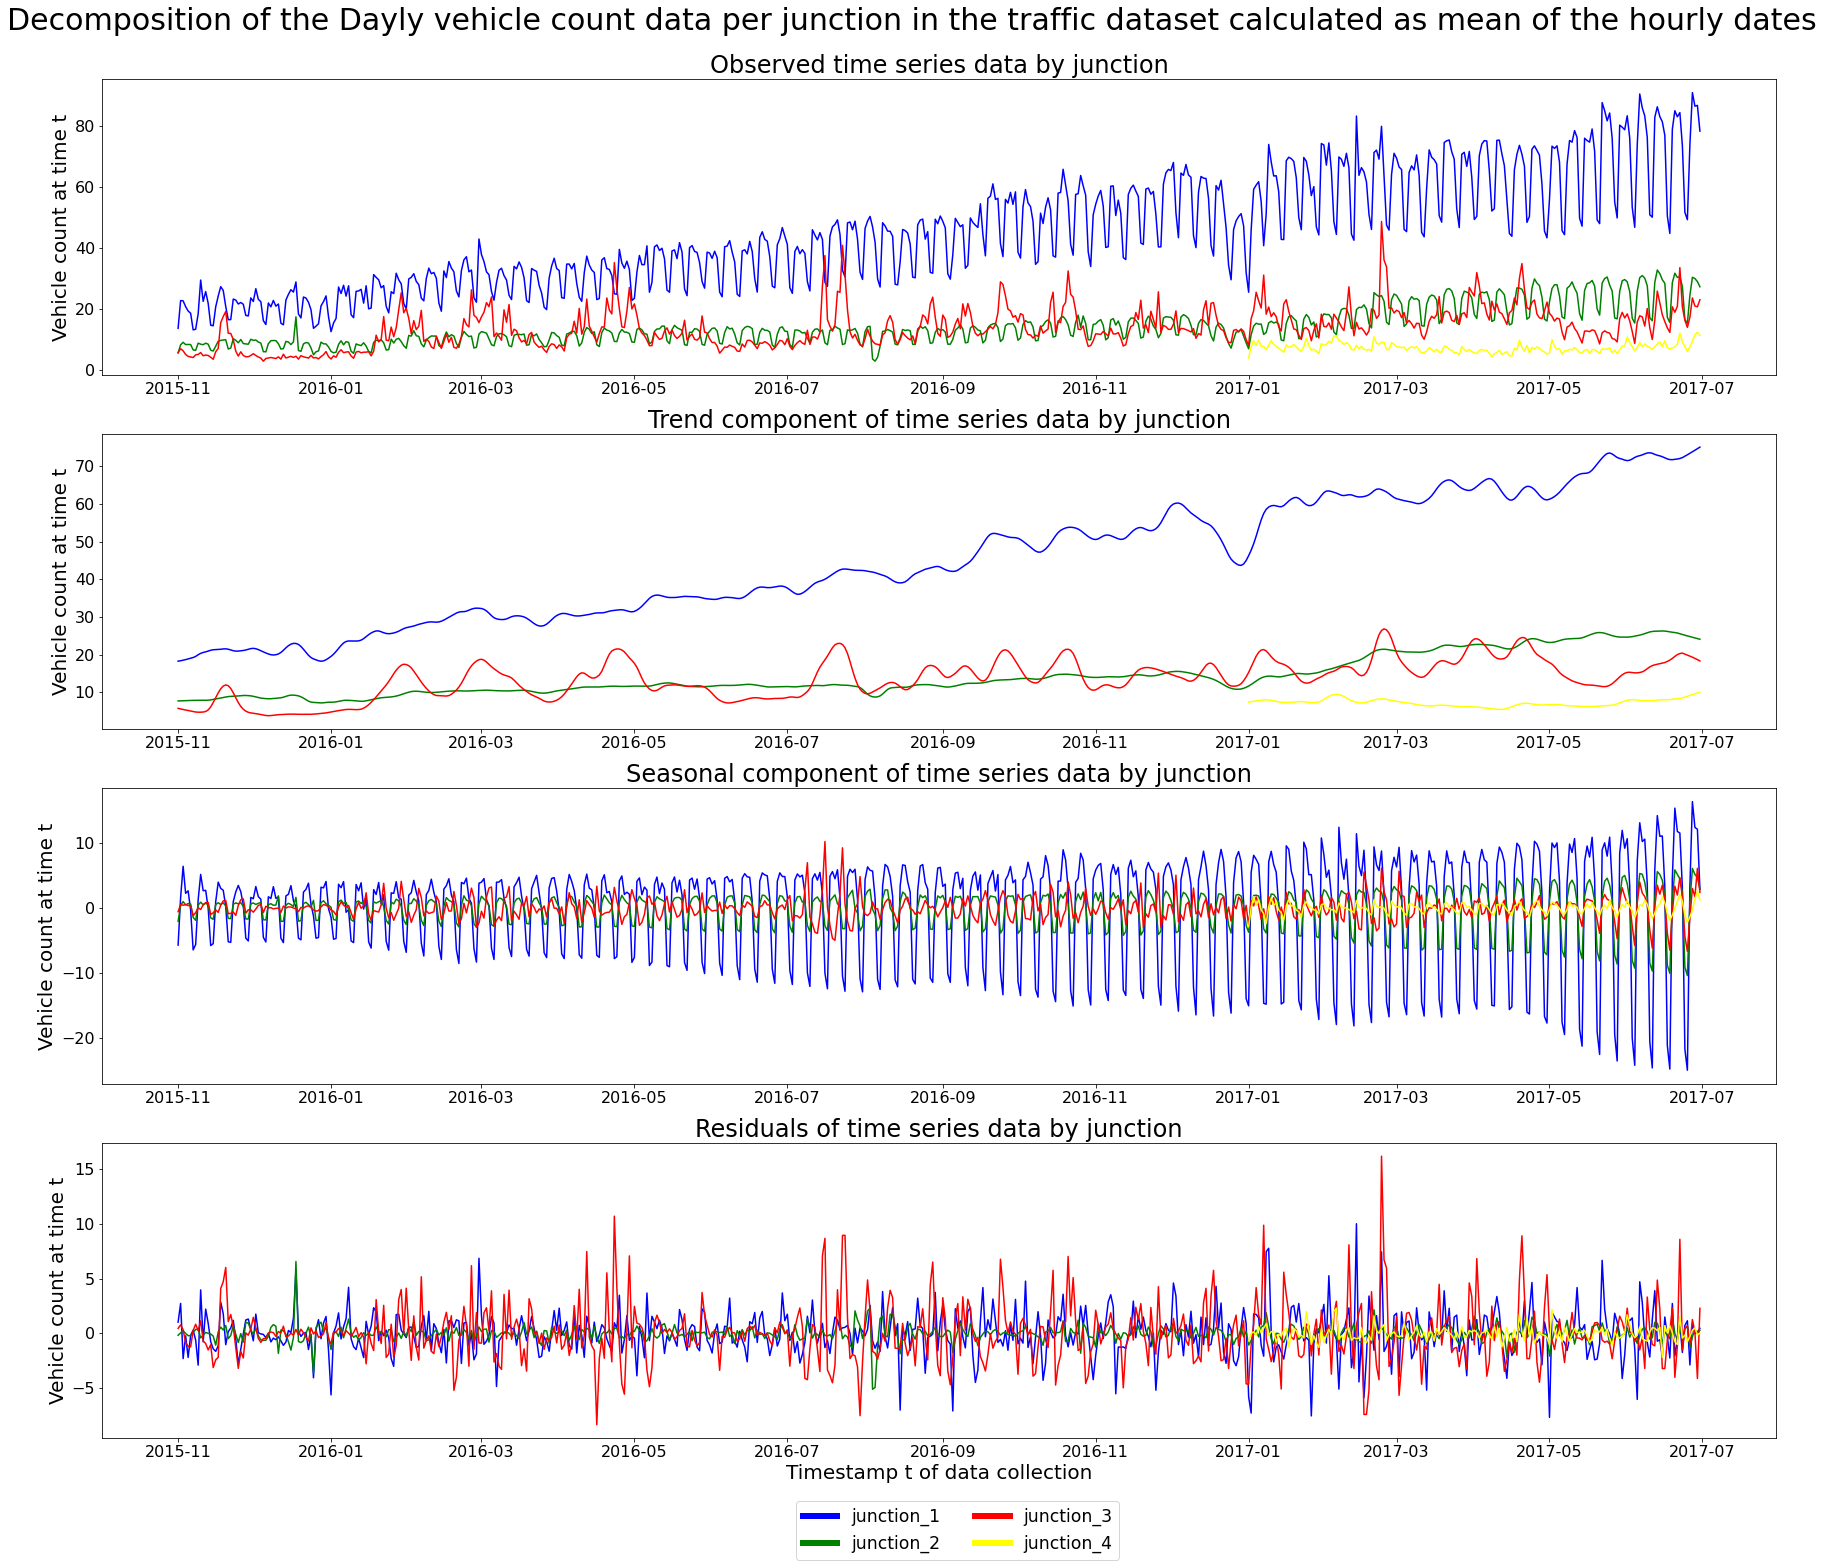

In [13]:
plot_all_junction_timeseries_decomposition_in_one_plot(grouped_datetime_data, "D")

In [14]:
def plot_autocorrelation_by_junctions(data_grouped_by_junction):
    fig, axs = plt.subplots(
        2, 
        2, 
        figsize=(20,25),
    )
    
    #fig.suptitle(
     #       "Histograms of the vehicle counts of the traffic dataset"
     #       " per junction with identicall x and y axis scale",
      #      fontsize=20,
     #   )
    
    column = 0
    row = 0
    
    for key, group in data_grouped_by_junction:
        #axs[column, row].set_title(
        #    "Histogram for vehicle count data at junction {0}".format(key),
        #    fontsize=18,
        #)
        #axs[column, row].set_xlabel("Vehicle count values", fontsize=14,)
        #axs[column, row].set_ylabel(
        #    "Occurence of specific vehicle count bin",
        #    fontsize=14,
        #)
        
        plot_acf(
            group["Vehicles"], 
            ax=axs[column, row],
            #title
            auto_ylims=True,
            vlines_kwargs = {"colors": junction_to_color_mapping[key]},
            color=junction_to_color_mapping[key],
        )

        
        column = 0 if key % 2 == 0 else column + 1
        row = row + 1 if column % 2 == 0 else row
        
    fig.tight_layout()
    fig.subplots_adjust(top=0.95)
    
    #plt.savefig("./eda_plots/traffic_dataset_vehicle_bar_plot.png")

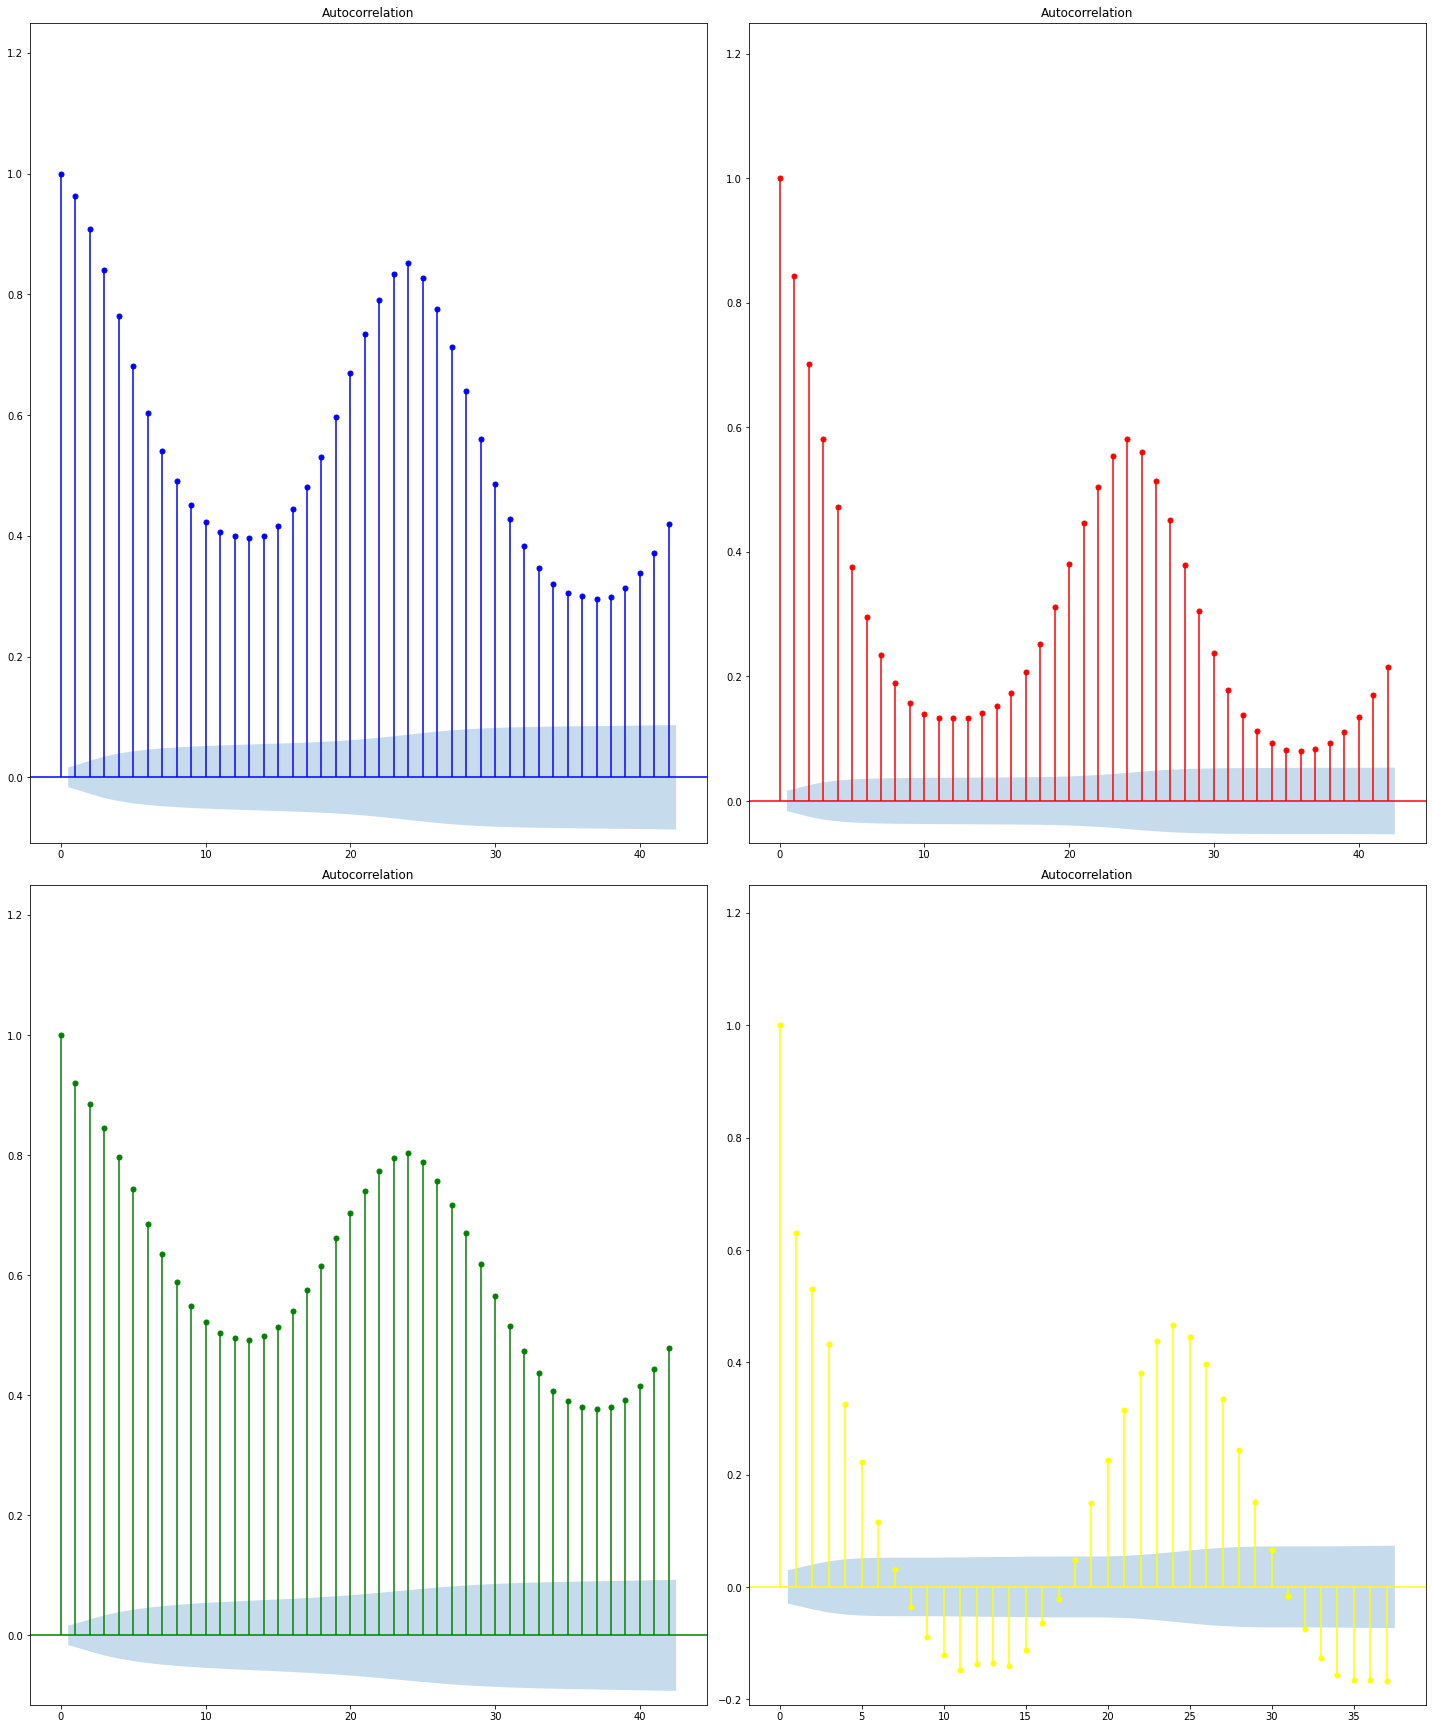

In [15]:
plot_autocorrelation_by_junctions(grouped_datetime_data)

In [ ]:
# => stat test ob statisch? => hätte das implikationen oder kann das durch preprocessing egal gemacht werden????

# Training

In [16]:
# metric_weighting: dict = {
#            'smape_weighting': 5,
#            'mae_weighting': 2,
#            'rmse_weighting': 2,
#            'made_weighting': 0.5,
#            'mage_weighting': 0,
#            'mle_weighting': 0,
#            'imle_weighting': 0,
#            'spl_weighting': 3,
#            'containment_weighting': 0,
#            'contour_weighting': 1,
#            'runtime_weighting': 0.05,
#            'oda_weighting': 0.001,
#        },

In [7]:
def prepare_filesystem_for_saving_results():
    for junction_number in range(1, 5):
        junction_result_folder = "./results_per_junction/junction_{0}".format(junction_number) 
        
        if not os.path.exists(junction_result_folder):
            os.makedirs(junction_result_folder)
            print("Directory {0} succesfully created.".format(junction_result_folder))
        else:    
            print("Directory {0} already exists.".format(junction_result_folder))
            
    for junction_result_folder in os.listdir("./results_per_junction"):
        try:
            os.mkdir("./results_per_junction/{0}/autots_model".format(junction_result_folder))
            os.mkdir("./results_per_junction/{0}/best_quarter_of_trained_models".format(junction_result_folder))
            os.mkdir("./results_per_junction/{0}/result_plots".format(junction_result_folder))
            os.mkdir(
                "./results_per_junction/{0}/"
                "result_tables_as_latex".format(junction_result_folder)
            )
            print(
                "Directories ./results_per_junction/{0}/autots_model,"
                " ./results_per_junction/{0}/result_plots,"
                " ./results_per_junction/{0}/best_quarter_of_trained_models"
                "and ./results_per_junction/{0}/result_tables_as_latex"
                " successfully created.".format(junction_result_folder)
            )
        except FileExistsError:
            print(
                "Directories ./results_per_junction/{0}/autots_model,"
                " ./results_per_junction/{0}/result_plots,"
                " ./results_per_junction/{0}/best_quarter_of_trained_models"
                "and ./results_per_junction/{0}/result_tables_as_latex" 
                " already existed.".format(junction_result_folder)
            )  
    
    try:
        os.mkdir("./combined_result_plots")
        print("Directory ./combined_result_plots successfully created.")
    except FileExistsError:
        print("Directory ./combined_result_plots already existed")  
    

def cleanup_filesystem():
    try:
        shutil.rmtree("./combined_result_plots")
    except OSError as e:
        print("Error: {0} : {1}".format("./combined_result_plots", e.strerror))
        
    try:
        shutil.rmtree("./results_per_junction")
    except OSError as e:
        print("Error: {0} : {1}".format("./results_per_junction", e.strerror))


def save_autots_model_results_per_single_junction(
    autots_model_single_junction,
    junction_key,
):
    filename = ("junction_{0}_trained_autots_model_junction_"       
                    "number_tuple.bin").format(junction_key)
        
    working_directory =os.getcwd()  # da lassen? eig nicht nötig?!
    base_path = "results_per_junction/junction_{0}/autots_model".format(junction_key)
        
    complete_path = "/".join([working_directory, base_path, filename])
        
    with open(complete_path, "wb") as f: # "wb" because we want to write in binary mode
        pickle.dump((autots_model_single_junction, junction_key), f)
            
            
        
def save_best_model_per_junctions_backforecast(
    best_model_single_junction,
    junction_num,
    #time_series_data_per_junction,
):
    filename = ("junction_{0}_best_trained_model_junction_"       
                    "backforecast.csv").format(junction_num)
        
    working_directory =os.getcwd()  # da lassen? eig nicht nötig?!
    base_path = "results_per_junction/junction_{0}/autots_model".format(junction_num)
        
    complete_path = "/".join([working_directory, base_path, filename])
                
    junction_backforecast = best_model_single_junction.back_forecast(
        column = "Vehicles",
        n_splits = "auto",
    ).forecast
        
    junction_backforecast.to_csv(complete_path)
        


def train_models_per_junction(data_grouped_by_junction, autots_param_dict):
    result_model_junction_key_list = []
    
    for key, group in data_grouped_by_junction:
        group.drop(["Junction"], axis=1, inplace=True)
        group["Vehicles"] = group["Vehicles"].astype("float64")

        autots_model = AutoTS(**autots_param_dict)
        
        junction_resulting_model = autots_model.fit(group)
        
        save_autots_model_results_per_single_junction(
            junction_resulting_model, 
            key
        )
        
        save_best_model_per_junctions_backforecast(
            junction_resulting_model, 
            key,
        )
        
        result_model_junction_key_list.append((junction_resulting_model, key))
        
    return result_model_junction_key_list    

In [8]:
#model_list="all",  
#transformer_list="all",
#drop_most_recent=1,
# explizit freq und models angeben (transformers nicht!?!)
  
model_dict = {
    'ConstantNaive': 1,
    'LastValueNaive': 1.5,
    'AverageValueNaive': 1,
    'GLS': 1,
    'SeasonalNaive': 1,
    'GLM': 1,
    'ETS': 1,
    'UnobservedComponents': 0.4,  # it's fast enough but I'll leave for parallel
    'WindowRegression': 0.3,  # this gets slow with Transformer, KerasRNN
    'DatepartRegression': 0.5,
    'UnivariateMotif': 1,
    'SectionalMotif': 1,
    'NVAR': 1,
    'FBProphet': 1,
}
    

autots_param_dict = {
    "forecast_length": 5,
    "frequency": "H",
    "prediction_interval": 0.9,
    "ensemble": None,
    "model_list": "superfast",
    "transformer_list": "superfast",
    "max_generations": 15,
    "num_validations": 5,
    "validation_method": "backwards",
    "n_jobs": 3,
    "no_negatives": True,
    "holiday_country": "US",
}


cleanup_filesystem()

prepare_filesystem_for_saving_results()

resulting_models = train_models_per_junction(grouped_datetime_data, autots_param_dict)

Directory ./results_per_junction/junction_1 succesfully created.
Directory ./results_per_junction/junction_2 succesfully created.
Directory ./results_per_junction/junction_3 succesfully created.
Directory ./results_per_junction/junction_4 succesfully created.
Directories ./results_per_junction/junction_4/autots_model, ./results_per_junction/junction_4/result_plots, ./results_per_junction/junction_4/best_quarter_of_trained_modelsand ./results_per_junction/junction_4/result_tables_as_latex successfully created.
Directories ./results_per_junction/junction_2/autots_model, ./results_per_junction/junction_2/result_plots, ./results_per_junction/junction_2/best_quarter_of_trained_modelsand ./results_per_junction/junction_2/result_tables_as_latex successfully created.
Directories ./results_per_junction/junction_1/autots_model, ./results_per_junction/junction_1/result_plots, ./results_per_junction/junction_1/best_quarter_of_trained_modelsand ./results_per_junction/junction_1/result_tables_as_lat

Model Number: 109 with model GLS in generation 3 of 15
Model Number: 110 with model GLS in generation 3 of 15
Model Number: 111 with model SeasonalNaive in generation 3 of 15
Model Number: 112 with model SeasonalNaive in generation 3 of 15
Model Number: 113 with model SeasonalNaive in generation 3 of 15
Model Number: 114 with model GLS in generation 3 of 15
Model Number: 115 with model SeasonalNaive in generation 3 of 15
New Generation: 4 of 15
Model Number: 116 with model SeasonalNaive in generation 4 of 15
Model Number: 117 with model GLS in generation 4 of 15
Model Number: 118 with model SeasonalNaive in generation 4 of 15
Model Number: 119 with model AverageValueNaive in generation 4 of 15
Model Number: 120 with model LastValueNaive in generation 4 of 15
Model Number: 121 with model AverageValueNaive in generation 4 of 15
Model Number: 122 with model LastValueNaive in generation 4 of 15
Model Number: 123 with model GLS in generation 4 of 15
Model Number: 124 with model LastValueNai

Model Number: 233 with model LastValueNaive in generation 9 of 15
Model Number: 234 with model AverageValueNaive in generation 9 of 15
Model Number: 235 with model LastValueNaive in generation 9 of 15
Model Number: 236 with model SeasonalNaive in generation 9 of 15
Model Number: 237 with model SeasonalNaive in generation 9 of 15
Model Number: 238 with model AverageValueNaive in generation 9 of 15
Model Number: 239 with model SeasonalNaive in generation 9 of 15
Model Number: 240 with model ConstantNaive in generation 9 of 15
New Generation: 10 of 15
Model Number: 241 with model AverageValueNaive in generation 10 of 15
Model Number: 242 with model AverageValueNaive in generation 10 of 15
Model Number: 243 with model SeasonalNaive in generation 10 of 15
Model Number: 244 with model LastValueNaive in generation 10 of 15
Model Number: 245 with model SeasonalNaive in generation 10 of 15
Model Number: 246 with model AverageValueNaive in generation 10 of 15
Model Number: 247 with model Average

📈 14 - AverageValueNaive with avg smape 3.91: 
Model Number: 15 of 50 with model AverageValueNaive for Validation 1
15 - AverageValueNaive with avg smape 10.17: 
Model Number: 16 of 50 with model AverageValueNaive for Validation 1
16 - AverageValueNaive with avg smape 10.15: 
Model Number: 17 of 50 with model AverageValueNaive for Validation 1
17 - AverageValueNaive with avg smape 9.71: 
Model Number: 18 of 50 with model AverageValueNaive for Validation 1
18 - AverageValueNaive with avg smape 4.59: 
Model Number: 19 of 50 with model AverageValueNaive for Validation 1
19 - AverageValueNaive with avg smape 4.6: 
Model Number: 20 of 50 with model LastValueNaive for Validation 1
20 - LastValueNaive with avg smape 40.39: 
Model Number: 21 of 50 with model LastValueNaive for Validation 1
21 - LastValueNaive with avg smape 40.5: 
Model Number: 22 of 50 with model AverageValueNaive for Validation 1
22 - AverageValueNaive with avg smape 9.77: 
Model Number: 23 of 50 with model LastValueNaive fo

43 - GLS with avg smape 12.78: 
Model Number: 44 of 50 with model GLS for Validation 2
44 - GLS with avg smape 42.52: 
Model Number: 45 of 50 with model GLS for Validation 2
45 - GLS with avg smape 56.05: 
Model Number: 46 of 50 with model ConstantNaive for Validation 2
46 - ConstantNaive with avg smape 60.1: 
Model Number: 47 of 50 with model GLS for Validation 2
47 - GLS with avg smape 34.9: 
Model Number: 48 of 50 with model GLS for Validation 2
48 - GLS with avg smape 32.58: 
Model Number: 49 of 50 with model ConstantNaive for Validation 2
49 - ConstantNaive with avg smape 32.59: 
Model Number: 50 of 50 with model ConstantNaive for Validation 2
50 - ConstantNaive with avg smape 23.06: 
Validation Round: 3
Model Number: 1 of 50 with model SeasonalNaive for Validation 3
📈 1 - SeasonalNaive with avg smape 39.89: 
Model Number: 2 of 50 with model SeasonalNaive for Validation 3
2 - SeasonalNaive with avg smape 39.89: 
Model Number: 3 of 50 with model SeasonalNaive for Validation 3
3 - S

21 - LastValueNaive with avg smape 44.57: 
Model Number: 22 of 50 with model AverageValueNaive for Validation 4
22 - AverageValueNaive with avg smape 30.58: 
Model Number: 23 of 50 with model LastValueNaive for Validation 4
23 - LastValueNaive with avg smape 37.88: 
Model Number: 24 of 50 with model LastValueNaive for Validation 4
24 - LastValueNaive with avg smape 36.49: 
Model Number: 25 of 50 with model LastValueNaive for Validation 4
25 - LastValueNaive with avg smape 37.59: 
Model Number: 26 of 50 with model LastValueNaive for Validation 4
26 - LastValueNaive with avg smape 37.59: 
Model Number: 27 of 50 with model LastValueNaive for Validation 4
27 - LastValueNaive with avg smape 36.64: 
Model Number: 28 of 50 with model LastValueNaive for Validation 4
28 - LastValueNaive with avg smape 36.64: 
Model Number: 29 of 50 with model LastValueNaive for Validation 4
29 - LastValueNaive with avg smape 43.21: 
Model Number: 30 of 50 with model LastValueNaive for Validation 4
30 - LastValu

/home/paettfish/.local/share/virtualenvs/experiments-mVQQwhcP/lib/python3.9/site-packages/autots/tools/probabilistic.py:67: RuntimeWarning: invalid value encountered in divide
  (prior_mu / prior_sigma**2) + ((n * data_mu) / prior_sigma**2)
/home/paettfish/.local/share/virtualenvs/experiments-mVQQwhcP/lib/python3.9/site-packages/autots/tools/probabilistic.py:68: RuntimeWarning: divide by zero encountered in divide
  ) / ((1 / prior_sigma**2) + (n / prior_sigma**2))
/home/paettfish/.local/share/virtualenvs/experiments-mVQQwhcP/lib/python3.9/site-packages/autots/tools/probabilistic.py:67: RuntimeWarning: invalid value encountered in divide
  (prior_mu / prior_sigma**2) + ((n * data_mu) / prior_sigma**2)
/home/paettfish/.local/share/virtualenvs/experiments-mVQQwhcP/lib/python3.9/site-packages/autots/tools/probabilistic.py:68: RuntimeWarning: divide by zero encountered in divide
  ) / ((1 / prior_sigma**2) + (n / prior_sigma**2))
/home/paettfish/.local/share/virtualenvs/experiments-mVQQwhc

Model Number: 1 with model AverageValueNaive in generation 0 of 15
Model Number: 2 with model AverageValueNaive in generation 0 of 15
Model Number: 3 with model AverageValueNaive in generation 0 of 15
Model Number: 4 with model GLS in generation 0 of 15
Model Number: 5 with model GLS in generation 0 of 15
Model Number: 6 with model LastValueNaive in generation 0 of 15
Model Number: 7 with model LastValueNaive in generation 0 of 15
Model Number: 8 with model LastValueNaive in generation 0 of 15
Model Number: 9 with model LastValueNaive in generation 0 of 15
Model Number: 10 with model SeasonalNaive in generation 0 of 15
Model Number: 11 with model SeasonalNaive in generation 0 of 15
Model Number: 12 with model SeasonalNaive in generation 0 of 15
Model Number: 13 with model ConstantNaive in generation 0 of 15
Model Number: 14 with model SeasonalNaive in generation 0 of 15
Model Number: 15 with model SeasonalNaive in generation 0 of 15
Model Number: 16 with model ConstantNaive in generati

Model Number: 130 with model SeasonalNaive in generation 4 of 15
Model Number: 131 with model SeasonalNaive in generation 4 of 15
Model Number: 132 with model GLS in generation 4 of 15
Model Number: 133 with model LastValueNaive in generation 4 of 15
Model Number: 134 with model SeasonalNaive in generation 4 of 15
Model Number: 135 with model LastValueNaive in generation 4 of 15
Model Number: 136 with model SeasonalNaive in generation 4 of 15
Model Number: 137 with model LastValueNaive in generation 4 of 15
Model Number: 138 with model AverageValueNaive in generation 4 of 15
Model Number: 139 with model LastValueNaive in generation 4 of 15
Model Number: 140 with model LastValueNaive in generation 4 of 15
New Generation: 5 of 15
Model Number: 141 with model LastValueNaive in generation 5 of 15
Model Number: 142 with model LastValueNaive in generation 5 of 15
Model Number: 143 with model SeasonalNaive in generation 5 of 15
Model Number: 144 with model LastValueNaive in generation 5 of 15

Model Number: 253 with model SeasonalNaive in generation 10 of 15
Model Number: 254 with model AverageValueNaive in generation 10 of 15
Model Number: 255 with model SeasonalNaive in generation 10 of 15
New Generation: 11 of 15
Model Number: 256 with model LastValueNaive in generation 11 of 15
Model Number: 257 with model AverageValueNaive in generation 11 of 15
Model Number: 258 with model LastValueNaive in generation 11 of 15
Model Number: 259 with model GLS in generation 11 of 15
Model Number: 260 with model AverageValueNaive in generation 11 of 15
Model Number: 261 with model LastValueNaive in generation 11 of 15
Model Number: 262 with model GLS in generation 11 of 15
Model Number: 263 with model LastValueNaive in generation 11 of 15
Model Number: 264 with model LastValueNaive in generation 11 of 15
Model Number: 265 with model AverageValueNaive in generation 11 of 15
Model Number: 266 with model AverageValueNaive in generation 11 of 15
Model Number: 267 with model AverageValueNaive

Model Number: 27 of 50 with model SeasonalNaive for Validation 1
27 - SeasonalNaive with avg smape 8.19: 
Model Number: 28 of 50 with model SeasonalNaive for Validation 1
28 - SeasonalNaive with avg smape 11.25: 
Model Number: 29 of 50 with model SeasonalNaive for Validation 1
29 - SeasonalNaive with avg smape 11.25: 
Model Number: 30 of 50 with model SeasonalNaive for Validation 1
30 - SeasonalNaive with avg smape 16.24: 
Model Number: 31 of 50 with model SeasonalNaive for Validation 1
31 - SeasonalNaive with avg smape 16.24: 
Model Number: 32 of 50 with model SeasonalNaive for Validation 1
32 - SeasonalNaive with avg smape 16.24: 
Model Number: 33 of 50 with model SeasonalNaive for Validation 1
33 - SeasonalNaive with avg smape 16.24: 
Model Number: 34 of 50 with model SeasonalNaive for Validation 1
34 - SeasonalNaive with avg smape 11.25: 
Model Number: 35 of 50 with model SeasonalNaive for Validation 1
35 - SeasonalNaive with avg smape 11.25: 
Model Number: 36 of 50 with model GLS 

Model Number: 6 of 50 with model AverageValueNaive for Validation 3
6 - AverageValueNaive with avg smape 57.15: 
Model Number: 7 of 50 with model AverageValueNaive for Validation 3
7 - AverageValueNaive with avg smape 57.15: 
Model Number: 8 of 50 with model AverageValueNaive for Validation 3
8 - AverageValueNaive with avg smape 57.15: 
Model Number: 9 of 50 with model AverageValueNaive for Validation 3
9 - AverageValueNaive with avg smape 57.15: 
Model Number: 10 of 50 with model AverageValueNaive for Validation 3
10 - AverageValueNaive with avg smape 60.09: 
Model Number: 11 of 50 with model AverageValueNaive for Validation 3
11 - AverageValueNaive with avg smape 60.09: 
Model Number: 12 of 50 with model GLS for Validation 3
📈 12 - GLS with avg smape 42.12: 
Model Number: 13 of 50 with model GLS for Validation 3
13 - GLS with avg smape 43.11: 
Model Number: 14 of 50 with model LastValueNaive for Validation 3
14 - LastValueNaive with avg smape 46.84: 
Model Number: 15 of 50 with model

33 - SeasonalNaive with avg smape 17.66: 
Model Number: 34 of 50 with model SeasonalNaive for Validation 4
34 - SeasonalNaive with avg smape 17.46: 
Model Number: 35 of 50 with model SeasonalNaive for Validation 4
35 - SeasonalNaive with avg smape 17.46: 
Model Number: 36 of 50 with model GLS for Validation 4
36 - GLS with avg smape 22.16: 
Model Number: 37 of 50 with model GLS for Validation 4
37 - GLS with avg smape 22.16: 
Model Number: 38 of 50 with model GLS for Validation 4
📈 38 - GLS with avg smape 16.22: 
Model Number: 39 of 50 with model GLS for Validation 4
39 - GLS with avg smape 17.13: 
Model Number: 40 of 50 with model GLS for Validation 4
40 - GLS with avg smape 17.04: 
Model Number: 41 of 50 with model GLS for Validation 4
41 - GLS with avg smape 17.04: 
Model Number: 42 of 50 with model GLS for Validation 4
42 - GLS with avg smape 17.03: 
Model Number: 43 of 50 with model GLS for Validation 4
43 - GLS with avg smape 17.05: 
Model Number: 44 of 50 with model GLS for Vali

Model Number: 21 with model GLS in generation 0 of 15
Model Number: 22 with model ConstantNaive in generation 0 of 15
Model Number: 23 with model LastValueNaive in generation 0 of 15
Model Number: 24 with model GLS in generation 0 of 15
Model Number: 25 with model LastValueNaive in generation 0 of 15
Model Number: 26 with model GLS in generation 0 of 15
Model Number: 27 with model GLS in generation 0 of 15
Model Number: 28 with model SeasonalNaive in generation 0 of 15
Model Number: 29 with model LastValueNaive in generation 0 of 15
Model Number: 30 with model LastValueNaive in generation 0 of 15
Model Number: 31 with model GLS in generation 0 of 15
Model Number: 32 with model ConstantNaive in generation 0 of 15
Model Number: 33 with model SeasonalNaive in generation 0 of 15
Model Number: 34 with model LastValueNaive in generation 0 of 15
Model Number: 35 with model ConstantNaive in generation 0 of 15
Model Number: 36 with model SeasonalNaive in generation 0 of 15
Model Number: 37 with

Model Number: 149 with model SeasonalNaive in generation 5 of 15
Model Number: 150 with model LastValueNaive in generation 5 of 15
Model Number: 151 with model LastValueNaive in generation 5 of 15
Model Number: 152 with model AverageValueNaive in generation 5 of 15
Model Number: 153 with model ConstantNaive in generation 5 of 15
Model Number: 154 with model AverageValueNaive in generation 5 of 15
Model Number: 155 with model SeasonalNaive in generation 5 of 15
Model Number: 156 with model SeasonalNaive in generation 5 of 15
Model Number: 157 with model AverageValueNaive in generation 5 of 15
Model Number: 158 with model ConstantNaive in generation 5 of 15
Model Number: 159 with model LastValueNaive in generation 5 of 15
Model Number: 160 with model SeasonalNaive in generation 5 of 15
New Generation: 6 of 15
Model Number: 161 with model LastValueNaive in generation 6 of 15
Model Number: 162 with model LastValueNaive in generation 6 of 15
Model Number: 163 with model LastValueNaive in ge

Model Number: 271 with model LastValueNaive in generation 12 of 15
Model Number: 272 with model LastValueNaive in generation 12 of 15
Model Number: 273 with model SeasonalNaive in generation 12 of 15
Model Number: 274 with model SeasonalNaive in generation 12 of 15
Model Number: 275 with model AverageValueNaive in generation 12 of 15
Model Number: 276 with model LastValueNaive in generation 12 of 15
Model Number: 277 with model SeasonalNaive in generation 12 of 15
Model Number: 278 with model LastValueNaive in generation 12 of 15
Model Number: 279 with model SeasonalNaive in generation 12 of 15
Model Number: 280 with model AverageValueNaive in generation 12 of 15
Model Number: 281 with model LastValueNaive in generation 12 of 15
Model Number: 282 with model SeasonalNaive in generation 12 of 15
Model Number: 283 with model SeasonalNaive in generation 12 of 15
Model Number: 284 with model SeasonalNaive in generation 12 of 15
Model Number: 285 with model LastValueNaive in generation 12 of

📈 39 - AverageValueNaive with avg smape 6.58: 
Model Number: 40 of 50 with model GLS for Validation 1
40 - GLS with avg smape 19.86: 
Model Number: 41 of 50 with model AverageValueNaive for Validation 1
41 - AverageValueNaive with avg smape 77.77: 
Model Number: 42 of 50 with model GLS for Validation 1
📈 42 - GLS with avg smape 6.17: 
Model Number: 43 of 50 with model GLS for Validation 1
43 - GLS with avg smape 6.42: 
Model Number: 44 of 50 with model GLS for Validation 1
44 - GLS with avg smape 6.42: 
Model Number: 45 of 50 with model GLS for Validation 1
45 - GLS with avg smape 6.42: 
Model Number: 46 of 50 with model GLS for Validation 1
46 - GLS with avg smape 56.63: 
Model Number: 47 of 50 with model ConstantNaive for Validation 1
47 - ConstantNaive with avg smape 6.53: 
Model Number: 48 of 50 with model ConstantNaive for Validation 1
48 - ConstantNaive with avg smape 6.42: 
Model Number: 49 of 50 with model ConstantNaive for Validation 1
49 - ConstantNaive with avg smape 6.42: 


17 - SeasonalNaive with avg smape 33.97: 
Model Number: 18 of 50 with model SeasonalNaive for Validation 3
18 - SeasonalNaive with avg smape 32.1: 
Model Number: 19 of 50 with model SeasonalNaive for Validation 3
19 - SeasonalNaive with avg smape 41.52: 
Model Number: 20 of 50 with model SeasonalNaive for Validation 3
20 - SeasonalNaive with avg smape 30.88: 
Model Number: 21 of 50 with model AverageValueNaive for Validation 3
21 - AverageValueNaive with avg smape 78.28: 
Model Number: 22 of 50 with model SeasonalNaive for Validation 3
22 - SeasonalNaive with avg smape 51.12: 
Model Number: 23 of 50 with model SeasonalNaive for Validation 3
23 - SeasonalNaive with avg smape 34.0: 
Model Number: 24 of 50 with model ConstantNaive for Validation 3
24 - ConstantNaive with avg smape 70.15: 
Model Number: 25 of 50 with model GLS for Validation 3
📈 25 - GLS with avg smape 24.16: 
Model Number: 26 of 50 with model AverageValueNaive for Validation 3
26 - AverageValueNaive with avg smape 78.24: 

44 - GLS with avg smape 53.78: 
Model Number: 45 of 50 with model GLS for Validation 4
45 - GLS with avg smape 53.78: 
Model Number: 46 of 50 with model GLS for Validation 4
46 - GLS with avg smape 39.56: 
Model Number: 47 of 50 with model ConstantNaive for Validation 4
47 - ConstantNaive with avg smape 53.47: 
Model Number: 48 of 50 with model ConstantNaive for Validation 4
48 - ConstantNaive with avg smape 53.79: 
Model Number: 49 of 50 with model ConstantNaive for Validation 4
49 - ConstantNaive with avg smape 53.79: 
Model Number: 50 of 50 with model GLS for Validation 4
50 - GLS with avg smape 52.92: 
Validation Round: 5
Model Number: 1 of 50 with model LastValueNaive for Validation 5
📈 1 - LastValueNaive with avg smape 11.87: 
Model Number: 2 of 50 with model LastValueNaive for Validation 5
2 - LastValueNaive with avg smape 11.87: 
Model Number: 3 of 50 with model LastValueNaive for Validation 5
3 - LastValueNaive with avg smape 11.87: 
Model Number: 4 of 50 with model LastValueN

/home/paettfish/.local/share/virtualenvs/experiments-mVQQwhcP/lib/python3.9/site-packages/autots/tools/probabilistic.py:67: RuntimeWarning: invalid value encountered in divide
  (prior_mu / prior_sigma**2) + ((n * data_mu) / prior_sigma**2)
/home/paettfish/.local/share/virtualenvs/experiments-mVQQwhcP/lib/python3.9/site-packages/autots/tools/probabilistic.py:68: RuntimeWarning: divide by zero encountered in divide
  ) / ((1 / prior_sigma**2) + (n / prior_sigma**2))
/home/paettfish/.local/share/virtualenvs/experiments-mVQQwhcP/lib/python3.9/site-packages/autots/tools/probabilistic.py:67: RuntimeWarning: invalid value encountered in divide
  (prior_mu / prior_sigma**2) + ((n * data_mu) / prior_sigma**2)
/home/paettfish/.local/share/virtualenvs/experiments-mVQQwhcP/lib/python3.9/site-packages/autots/tools/probabilistic.py:68: RuntimeWarning: divide by zero encountered in divide
  ) / ((1 / prior_sigma**2) + (n / prior_sigma**2))
/home/paettfish/.local/share/virtualenvs/experiments-mVQQwhc

Model Number: 1 with model AverageValueNaive in generation 0 of 15
Model Number: 2 with model AverageValueNaive in generation 0 of 15
Model Number: 3 with model AverageValueNaive in generation 0 of 15
Model Number: 4 with model GLS in generation 0 of 15
Model Number: 5 with model GLS in generation 0 of 15
Model Number: 6 with model LastValueNaive in generation 0 of 15
Model Number: 7 with model LastValueNaive in generation 0 of 15
Model Number: 8 with model LastValueNaive in generation 0 of 15
Model Number: 9 with model LastValueNaive in generation 0 of 15
Model Number: 10 with model SeasonalNaive in generation 0 of 15
Model Number: 11 with model SeasonalNaive in generation 0 of 15
Model Number: 12 with model SeasonalNaive in generation 0 of 15
Model Number: 13 with model ConstantNaive in generation 0 of 15
Model Number: 14 with model SeasonalNaive in generation 0 of 15
Model Number: 15 with model SeasonalNaive in generation 0 of 15
Model Number: 16 with model ConstantNaive in generati

Model Number: 130 with model SeasonalNaive in generation 4 of 15
Model Number: 131 with model SeasonalNaive in generation 4 of 15
Model Number: 132 with model SeasonalNaive in generation 4 of 15
Model Number: 133 with model AverageValueNaive in generation 4 of 15
Model Number: 134 with model ConstantNaive in generation 4 of 15
Model Number: 135 with model LastValueNaive in generation 4 of 15
Model Number: 136 with model GLS in generation 4 of 15
Model Number: 137 with model AverageValueNaive in generation 4 of 15
Model Number: 138 with model LastValueNaive in generation 4 of 15
Model Number: 139 with model AverageValueNaive in generation 4 of 15
Model Number: 140 with model ConstantNaive in generation 4 of 15
New Generation: 5 of 15
Model Number: 141 with model AverageValueNaive in generation 5 of 15
Model Number: 142 with model AverageValueNaive in generation 5 of 15
Model Number: 143 with model SeasonalNaive in generation 5 of 15
Model Number: 144 with model SeasonalNaive in generati

Model Number: 255 with model SeasonalNaive in generation 10 of 15
New Generation: 11 of 15
Model Number: 256 with model LastValueNaive in generation 11 of 15
Model Number: 257 with model LastValueNaive in generation 11 of 15
Model Number: 258 with model SeasonalNaive in generation 11 of 15
Model Number: 259 with model LastValueNaive in generation 11 of 15
Model Number: 260 with model SeasonalNaive in generation 11 of 15
Model Number: 261 with model SeasonalNaive in generation 11 of 15
Model Number: 262 with model SeasonalNaive in generation 11 of 15
Model Number: 263 with model SeasonalNaive in generation 11 of 15
Model Number: 264 with model AverageValueNaive in generation 11 of 15
Model Number: 265 with model LastValueNaive in generation 11 of 15
Model Number: 266 with model SeasonalNaive in generation 11 of 15
Model Number: 267 with model SeasonalNaive in generation 11 of 15
Model Number: 268 with model LastValueNaive in generation 11 of 15
Model Number: 269 with model GLS in genera

29 - GLS with avg smape 26.98: 
Model Number: 30 of 50 with model GLS for Validation 1
30 - GLS with avg smape 26.98: 
Model Number: 31 of 50 with model GLS for Validation 1
31 - GLS with avg smape 31.03: 
Model Number: 32 of 50 with model GLS for Validation 1
32 - GLS with avg smape 30.09: 
Model Number: 33 of 50 with model AverageValueNaive for Validation 1
33 - AverageValueNaive with avg smape 30.09: 
Model Number: 34 of 50 with model AverageValueNaive for Validation 1
34 - AverageValueNaive with avg smape 30.09: 
Model Number: 35 of 50 with model AverageValueNaive for Validation 1
35 - AverageValueNaive with avg smape 30.53: 
Model Number: 36 of 50 with model GLS for Validation 1
36 - GLS with avg smape 29.63: 
Model Number: 37 of 50 with model GLS for Validation 1
37 - GLS with avg smape 30.02: 
Model Number: 38 of 50 with model GLS for Validation 1
38 - GLS with avg smape 30.06: 
Model Number: 39 of 50 with model GLS for Validation 1
39 - GLS with avg smape 30.06: 
Model Number: 

8 - SeasonalNaive with avg smape 36.21: 
Model Number: 9 of 50 with model SeasonalNaive for Validation 3
9 - SeasonalNaive with avg smape 36.21: 
Model Number: 10 of 50 with model SeasonalNaive for Validation 3
10 - SeasonalNaive with avg smape 36.21: 
Model Number: 11 of 50 with model SeasonalNaive for Validation 3
11 - SeasonalNaive with avg smape 36.21: 
Model Number: 12 of 50 with model LastValueNaive for Validation 3
📈 12 - LastValueNaive with avg smape 17.91: 
Model Number: 13 of 50 with model LastValueNaive for Validation 3
13 - LastValueNaive with avg smape 17.91: 
Model Number: 14 of 50 with model LastValueNaive for Validation 3
14 - LastValueNaive with avg smape 17.91: 
Model Number: 15 of 50 with model LastValueNaive for Validation 3
15 - LastValueNaive with avg smape 17.91: 
Model Number: 16 of 50 with model LastValueNaive for Validation 3
16 - LastValueNaive with avg smape 17.91: 
Model Number: 17 of 50 with model LastValueNaive for Validation 3
17 - LastValueNaive with av

37 - GLS with avg smape 67.9: 
Model Number: 38 of 50 with model GLS for Validation 4
38 - GLS with avg smape 67.88: 
Model Number: 39 of 50 with model GLS for Validation 4
39 - GLS with avg smape 67.88: 
Model Number: 40 of 50 with model GLS for Validation 4
40 - GLS with avg smape 64.2: 
Model Number: 41 of 50 with model AverageValueNaive for Validation 4
41 - AverageValueNaive with avg smape 67.88: 
Model Number: 42 of 50 with model AverageValueNaive for Validation 4
42 - AverageValueNaive with avg smape 67.88: 
Model Number: 43 of 50 with model AverageValueNaive for Validation 4
43 - AverageValueNaive with avg smape 67.9: 
Model Number: 44 of 50 with model AverageValueNaive for Validation 4
44 - AverageValueNaive with avg smape 66.47: 
Model Number: 45 of 50 with model ConstantNaive for Validation 4
📈 45 - ConstantNaive with avg smape 39.65: 
Model Number: 46 of 50 with model ConstantNaive for Validation 4
46 - ConstantNaive with avg smape 67.6: 
Model Number: 47 of 50 with model C

/home/paettfish/.local/share/virtualenvs/experiments-mVQQwhcP/lib/python3.9/site-packages/autots/tools/probabilistic.py:67: RuntimeWarning: invalid value encountered in divide
  (prior_mu / prior_sigma**2) + ((n * data_mu) / prior_sigma**2)
/home/paettfish/.local/share/virtualenvs/experiments-mVQQwhcP/lib/python3.9/site-packages/autots/tools/probabilistic.py:68: RuntimeWarning: divide by zero encountered in divide
  ) / ((1 / prior_sigma**2) + (n / prior_sigma**2))
/home/paettfish/.local/share/virtualenvs/experiments-mVQQwhcP/lib/python3.9/site-packages/autots/tools/probabilistic.py:67: RuntimeWarning: invalid value encountered in divide
  (prior_mu / prior_sigma**2) + ((n * data_mu) / prior_sigma**2)
/home/paettfish/.local/share/virtualenvs/experiments-mVQQwhcP/lib/python3.9/site-packages/autots/tools/probabilistic.py:68: RuntimeWarning: divide by zero encountered in divide
  ) / ((1 / prior_sigma**2) + (n / prior_sigma**2))
/home/paettfish/.local/share/virtualenvs/experiments-mVQQwhc

In [33]:
def load_trained_models_from_file():
    base_dir = "./results_per_junction"
    generic_model_dirs = "junction_{0}"
    generic_fn = "junction_{0}_trained_autots_model_junction_number_tuple.bin"
    
    trained_model_junction_num_tuple_list = []
    
    for junction_number in range(1, 5):
        filepath = "/".join(
            [
                base_dir, 
                generic_model_dirs.format(junction_number), 
                "autots_model", 
                generic_fn.format(junction_number)
            ]
        )
                
        with open(filepath, "rb") as f: # "wb" because we want to write in binary mode
            trained_model_junction_num_tuple = pickle.load(f)  
            
        trained_model_junction_num_tuple_list.append(
            trained_model_junction_num_tuple
        )
        
    return trained_model_junction_num_tuple_list


def create_best_model_scores_per_junction_bar_plot(best_model_junction_num_tuple_list):
    fig, ax = plt.subplots(figsize=(8,5))
    
    score_list = []
    junction_num_list = []
    color_list = []
    
    for autots_model, junction_num in best_model_junction_num_tuple_list:
        model_results = autots_model.results("validation")
        
        best_model_index = autots_model.best_model.index
        
        score = model_results.iloc[best_model_index]["Score"].values
        
        score_list.append(*score)
        junction_num_list.append(junction_num)
        color_list.append(junction_to_color_mapping[junction_num])
        
    ax.bar(junction_num_list, score_list, color=color_list)
    
    ax.set_xticks(junction_num_list)
    ax.set_xticklabels(
        map(lambda x: "junction_{0}".format(x), junction_num_list)
    )
    #ax.set_title("Number of datapoints available in the traffic dataset per junction", fontsize=15)
    #ax.set_xlabel("Junctions present in the traffic dataset")
    #ax.set_ylabel("Number of available datapoints")
    
    #plt.savefig("./eda_plots/traffic_dataset_datapoint_per_junction_bar_plot.png")
    

def create_model_count_in_best_worst_quarter_of_models_per_junction_bar_plot(
    best_model_junction_num_tuple_list
):
    for model, junction_num in best_model_junction_num_tuple_list:
        results = model.results("validation")
        val_results = results.loc[results["Runs"] == 6].sort_values(by=["Score"])
        
        n_quarter = round(len(val_results) / 4)
        
        quarter_best_models = val_results.head(n_quarter)[["Model", "ID"]]
        quarter_worst_models = val_results.tail(n_quarter)[["Model", "ID"]]
        
        quarter_best_model_counts = quarter_best_models.groupby(["Model"]).count()
        quarter_worst_model_counts = quarter_worst_models.groupby(["Model"]).count()
        
        fig, axs = plt.subplots(
            1, 
            2, 
            figsize=(15,7),
        )
        
        fig.suptitle(
            (
                "Specific model count in best and worst"      
                " performing models quarter on junction_{0} data"
            ).format(junction_num)
        )
        
        axs[0].bar(
            quarter_best_model_counts.index, 
            quarter_best_model_counts["ID"],
            color = junction_to_color_mapping[junction_num],
        )
        axs[0].set_title("Model count in best performing quarter of trained models")


        axs[1].bar(
            quarter_worst_model_counts.index,
            quarter_worst_model_counts["ID"],
            color = junction_to_color_mapping[junction_num],
        )
        axs[1].set_title("Model count in worst performing quarter of trained models")
        
        # y-achse beschriften!!!!! ggf. auch x?!?!?!

        
        
def create_model_count_in_best_worst_quarter_of_models_bar_plot(
    best_model_junction_num_tuple_list
):
    all_junctions_best_quarter_models = pd.DataFrame()
    all_junctions_worst_quarter_models = pd.DataFrame()

    
    for model, junction_num in best_model_junction_num_tuple_list:
        results = model.results("validation")
        val_results = results.loc[results["Runs"] == 6].sort_values(by=["Score"])
        
        n_quarter = round(len(val_results) / 4)
        
        quarter_best_models = val_results.head(n_quarter)[["Model", "ID"]]
        quarter_worst_models = val_results.tail(n_quarter)[["Model", "ID"]]
        
        all_junctions_best_quarter_models = pd.concat(
            [
                all_junctions_best_quarter_models,
                quarter_best_models,
            ]
        )
        
        all_junctions_worst_quarter_models = pd.concat(
            [
                all_junctions_worst_quarter_models,
                quarter_worst_models,
            ]
        )
    
    quarter_best_model_counts = all_junctions_best_quarter_models.groupby(["Model"]).count()
    quarter_worst_model_counts = all_junctions_worst_quarter_models.groupby(["Model"]).count()
        
    fig, axs = plt.subplots(
        1, 
        2, 
        figsize=(15,7),
    )
        
    fig.suptitle(
        (
            "Specific model count in best and worst"      
            " performing models quarter combined from all junctions" 
        ).format(junction_num),
        fontsize = 18,
    )
        
    axs[0].bar(
        quarter_best_model_counts.index, 
        quarter_best_model_counts["ID"],    
        color = "silver",    
    )
        
    axs[0].set_title(
        "Model count in best performing quarter of trained models",
        fontsize = 14,
    )

    axs[1].bar(
        quarter_worst_model_counts.index,
        quarter_worst_model_counts["ID"],
        color = "silver",    
    )
    axs[1].set_title(
        "Model count in worst performing quarter of trained models",
        fontsize = 14,
    )
    
    plt.savefig("./combined_result_plots/model_count_in_best_worst_quarter_of_models_bar_plot.png")



    
def create_backforecast_plot(
    time_series_data,
    best_model_junction_num_tuple_list, 
    start_date = datetime(2015, 11, 1, 0, 0, 0)
):
    fig, axs = plt.subplots(
        2, 
        2, 
        figsize=(20,15),
    )
    
    column = 0
    row = 0
    
    time_series_data_groups = time_series_data.groupby(["Junction"])
    
    for model, junction_num in best_model_junction_num_tuple_list:
        filename = ("junction_{0}_best_trained_model_junction_"       
                    "backforecast.csv").format(junction_num)
        
        working_directory =os.getcwd()  # da lassen? eig nicht nötig?!
        base_path = "results_per_junction/junction_{0}/autots_model".format(junction_num)
        
        complete_path = "/".join([working_directory, base_path, filename])
        
        junction_backforecast = pd.read_csv(
            complete_path, 
            parse_dates=True,
            header=0,
            names=["DateTime", "Vehicles"],
            index_col="DateTime",
        )
        
        junction_data = time_series_data_groups.get_group(junction_num)["Vehicles"]
                
        reduced_forecast = junction_backforecast[start_date:]
        reduced_data = junction_data[start_date:]
        
        axs[column, row].plot(
            reduced_data, 
            color = junction_to_color_mapping[junction_num],
            label = "junction_{0}".format(junction_num)
        )
        
        axs[column, row].plot(
            reduced_forecast,
            color = "black",
            label = "model_forecast" if junction_num ==1 else None
        )
        
        axs[column, row].set_title(
            "Kreuzung {0}".format(junction_num),
            fontsize = 22,
        )
        
        axs[column, row].tick_params(labelsize=16)
        axs[column, row].tick_params(axis='x', labelrotation = 45)
        
        column = 0 if junction_num % 2 == 0 else column + 1
        row = row + 1 if column % 2 == 0 else row
        
    leg = fig.legend(
        fontsize="xx-large", 
        ncol = 2,
        bbox_to_anchor =(0.65, 0.095)
    )
    
    for line in leg.get_lines():
            line.set_linewidth(6)
            
    fig.tight_layout(h_pad=2.0)
    fig.subplots_adjust(bottom=0.175)
    
    fig.savefig(
        "./combined_result_plots/backforecast_per_junction_plot.png",
        facecolor = "w",
    )

    
def save_best_quarter_of_models_per_junction(best_model_junction_num_tuple_list):
    generic_path = (
        " ./results_per_junction/{0}/"
        "best_quarter_of_trained_models/"
        "models.csv"
    )
    
    for model, junction_num in best_model_junction_num_tuple_list:
        results = model.results("validation")
        val_results = results.loc[results["Runs"] == 6].sort_values(by=["Score"])
        
        n_quarter = round(len(val_results) / 4)
        
        model.export_template(
            generic_path.format(junction_num), 
            models="best",          
            n=n_quarter, 
        )
        
        
def safe_model_occurences_in_best_quarter_as_latex_table_per_junction(
    best_model_junction_num_tuple_list
):
    working_directory =os.getcwd() # notwendig? denke nicht!
    generic_base_path = "/".join(
        [
            working_directory,
            "results_per_junction/junction_{0}/result_tables_as_latex/"
        ]
    )
    fn_best = "model_occurence_best_quarter_junction_{0}.tex"
    fn_worst = "model_occurence_worst_quarter_junction_{0}.tex"
    
    for model, junction_num in best_model_junction_num_tuple_list:
        results = model.results("validation")
        val_results = results.loc[results["Runs"] == 6].sort_values(by=["Score"])
        
        n_quarter = round(len(val_results) / 4)
        
        quarter_best_models = val_results.head(n_quarter)[["Model", "ID"]]
        quarter_worst_models = val_results.tail(n_quarter)[["Model", "ID"]]
        
        quarter_best_model_counts = quarter_best_models.groupby(["Model"]).count()
        quarter_worst_model_counts = quarter_worst_models.groupby(["Model"]).count()
        
        quarter_best_model_counts.columns = ["occurence"]
        quarter_worst_model_counts.columns = ["occurence"]
 

        best_path = "".join(
            [
                generic_base_path.format(junction_num),
                fn_best.format(junction_num)
            ]
        )
    
        worst_path = "".join(
            [
                generic_base_path.format(junction_num),
                fn_worst.format(junction_num)
            ]
        )
        
        quarter_best_model_counts.to_latex(
            buf = best_path,
            header = True,
            index = False,
            longtable = True,
            #caption = ,
        )
        
        quarter_worst_model_counts.to_latex(
            buf = worst_path,
            header = True,
            index = False,
            longtable = True,
            #caption = ,
        )
        

        
def safe_complete_autots_results_as_latex_table_per_junction(
    best_model_junction_num_tuple_list
):
    generic_base_path = "./results_per_junction/junction_{0}/result_tables_as_latex/"
    
    fn_train_results = "autots_model_train_results_junction_{0}.tex"
    fn_val_results = "autots_model_val_results_junction_{0}.tex"
    
    
    for model, junction_num in best_model_junction_num_tuple_list:
        train_results = model.results()
        val_results = model.results("validation")
        
        train_path = "".join(
            [
                generic_base_path.format(junction_num),
                fn_train_results.format(junction_num),
            ]
        )
        
        val_path = "".join(
            [
                generic_base_path.format(junction_num),
                fn_val_results.format(junction_num),
            ]
        )
        
        
        train_results.to_latex(
            buf = train_path,
            header = True,
            index = False,
            longtable = True,
            #caption = ,
        )
        
        val_results.to_latex(
            buf = val_path,
            header = True,
            index = False,
            longtable = True,
            #caption = ,
        )

        
    
def create_report_materials_out_of_trained_models():
    trained_model_junction_num_tuple_list = load_trained_models_from_file()
    
    create_best_model_scores_per_junction_bar_plot(  # => funk nutzen für tabelle!!!!!!!!!!!!!!!!!!!
        trained_model_junction_num_tuple_list
    )
    
    
    create_model_count_in_best_worst_quarter_of_models_per_junction_bar_plot(
        trained_model_junction_num_tuple_list
    )
    
    create_model_count_in_best_worst_quarter_of_models_bar_plot(
        trained_model_junction_num_tuple_list
    )
    
    safe_model_occurences_in_best_quarter_as_latex_table_per_junction(
        trained_model_junction_num_tuple_list
    )
    
    
    safe_complete_autots_results_as_latex_table_per_junction(
        trained_model_junction_num_tuple_list
    )
    
    create_backforecast_plot(
        data,
        trained_model_junction_num_tuple_list, 
        datetime(2017, 6, 15, 0, 0, 0)
    )
    
    
        
    # avg score by model/ model group
    
    # ggf. generation loss per junction plot????

FileNotFoundError: [Errno 2] No such file or directory: '/home/paettfish/git/uni/master/iot/experiments/results_per_junction/junction_1/result_tables_as_latex/model_occurence_best_quarter_junction_1.tex'

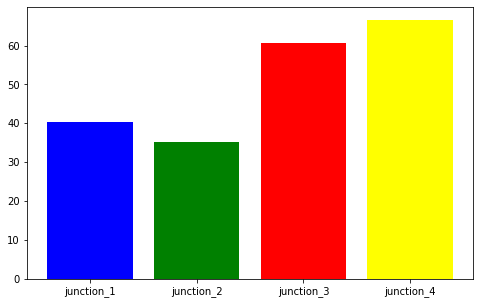

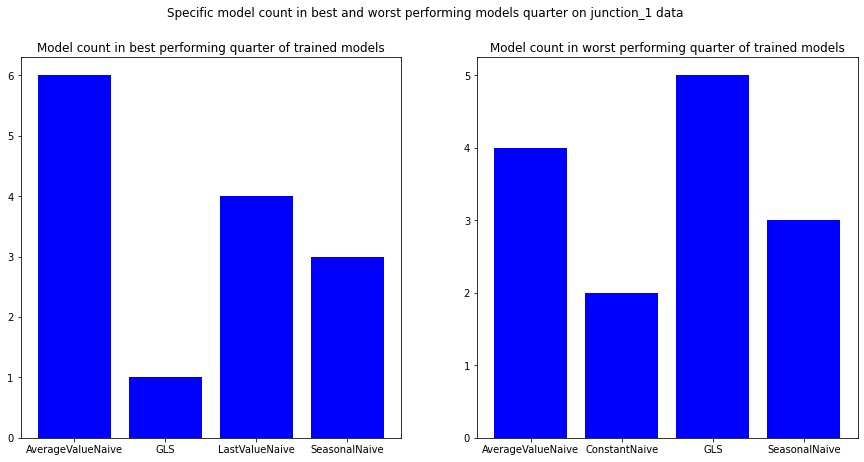

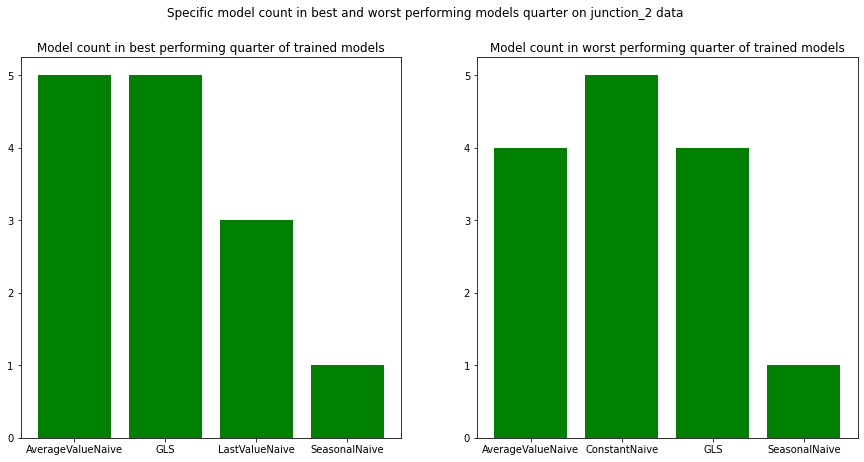

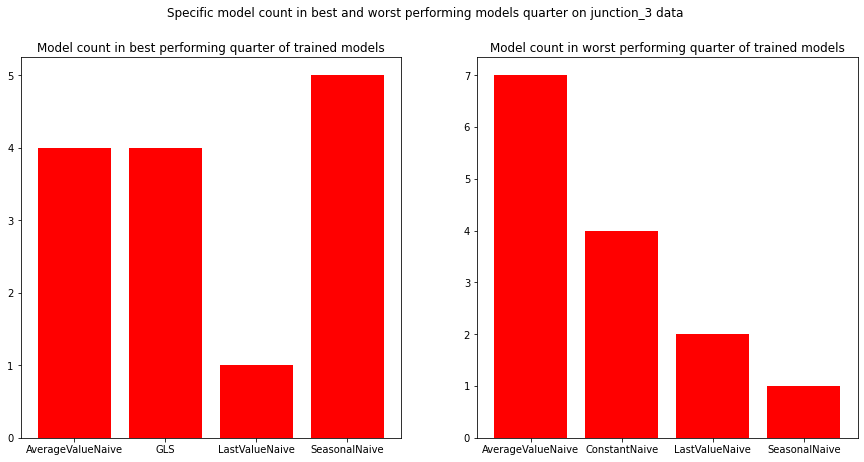

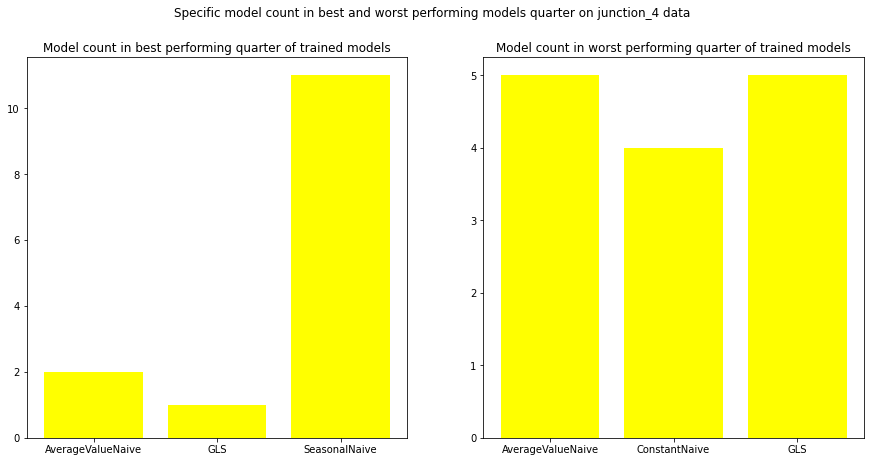

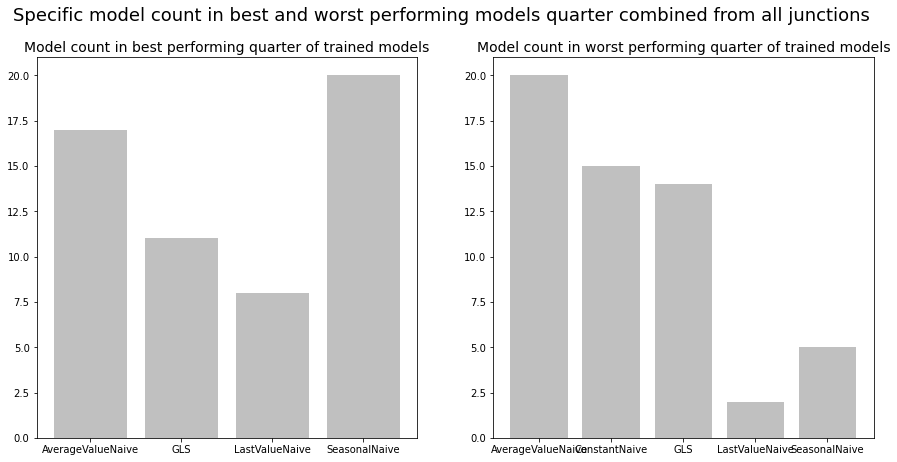

In [34]:
create_report_materials_out_of_trained_models()

In [ ]:
def create_best_model_scores_per_junction_table(best_model_junction_num_tuple_list):
    score_list = []
    junction_num_list = []
    model_name_list = []
    
    for autots_model, junction_num in best_model_junction_num_tuple_list:
        model_results = autots_model.results("validation")
        
        best_model_index = autots_model.best_model.index
        
        score = model_results.iloc[best_model_index]["Score"].values
        
        score_list.append(*score)
        junction_num_list.append(junction_num)
        model_name_list.append(autots_model.best_model_name)
        
    best_model_result_table = pd.DataFrame(
        {
            "Kreuzung": junction_num_list,
            "Modell": model_name_list,
            "Zielmetrikwert": score_list,
        }
    )
    
    return best_model_result_table

In [ ]:
trained_model_junction_num_tuple_list = load_trained_models_from_file()
    
result_table = create_best_model_scores_per_junction_table(
        trained_model_junction_num_tuple_list
    )
    
from IPython.display import HTML
HTML(result_table.to_html(index=False))